In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import interpolate
from dateutil.relativedelta import relativedelta
import gurobipy as gp
from gurobipy import GRB
import requests

In [68]:
# Liability schedule from the project description
liability_data = {
    'Date': [
        'Mar 2026', 'Sep 2026', 'Mar 2027', 'Sep 2027',
        'Mar 2028', 'Sep 2028', 'Mar 2029', 'Sep 2029',
        'Mar 2030', 'Sep 2030', 'Mar 2031', 'Sep 2031',
        'Mar 2032', 'Sep 2032', 'Mar 2033', 'Sep 2033'
    ],
    'Payment_Million': [8, 10, 11, 9, 10, 9, 12, 8, 10, 7, 5, 8, 7, 10, 9, 10]
}

liability_dates = [
    datetime(2026, 3, 31), datetime(2026, 9, 30),
    datetime(2027, 3, 31), datetime(2027, 9, 30),
    datetime(2028, 3, 31), datetime(2028, 9, 30),
    datetime(2029, 3, 31), datetime(2029, 9, 30),
    datetime(2030, 3, 31), datetime(2030, 9, 30),
    datetime(2031, 3, 31), datetime(2031, 9, 30),
    datetime(2032, 3, 31), datetime(2032, 9, 30),
    datetime(2033, 3, 31), datetime(2033, 9, 30)
]


liabilities_df = pd.DataFrame({
    'Date': liability_dates,
    'Payment_Million': liability_data['Payment_Million']
})

print("Liability Payment Schedule:")
print(liabilities_df.to_string(index=False))
print(f"\nTotal Liabilities: ${liabilities_df['Payment_Million'].sum():.2f} million")

Liability Payment Schedule:
      Date  Payment_Million
2026-03-31                8
2026-09-30               10
2027-03-31               11
2027-09-30                9
2028-03-31               10
2028-09-30                9
2029-03-31               12
2029-09-30                8
2030-03-31               10
2030-09-30                7
2031-03-31                5
2031-09-30                8
2032-03-31                7
2032-09-30               10
2033-03-31                9
2033-09-30               10

Total Liabilities: $143.00 million


US Treasury Par Yield Curve (October 8, 2025):
Maturity  Years  Yield_Pct  Yield_Decimal
    3 Mo  0.250       4.01         0.0401
    4 Mo  0.333       3.94         0.0394
    6 Mo  0.500       3.82         0.0382
    1 Yr  1.000       3.66         0.0366
    2 Yr  2.000       3.58         0.0358
    3 Yr  3.000       3.58         0.0358
    5 Yr  5.000       3.72         0.0372
    7 Yr  7.000       3.91         0.0391
   10 Yr 10.000       4.13         0.0413
   20 Yr 20.000       4.69         0.0469
   30 Yr 30.000       4.72         0.0472


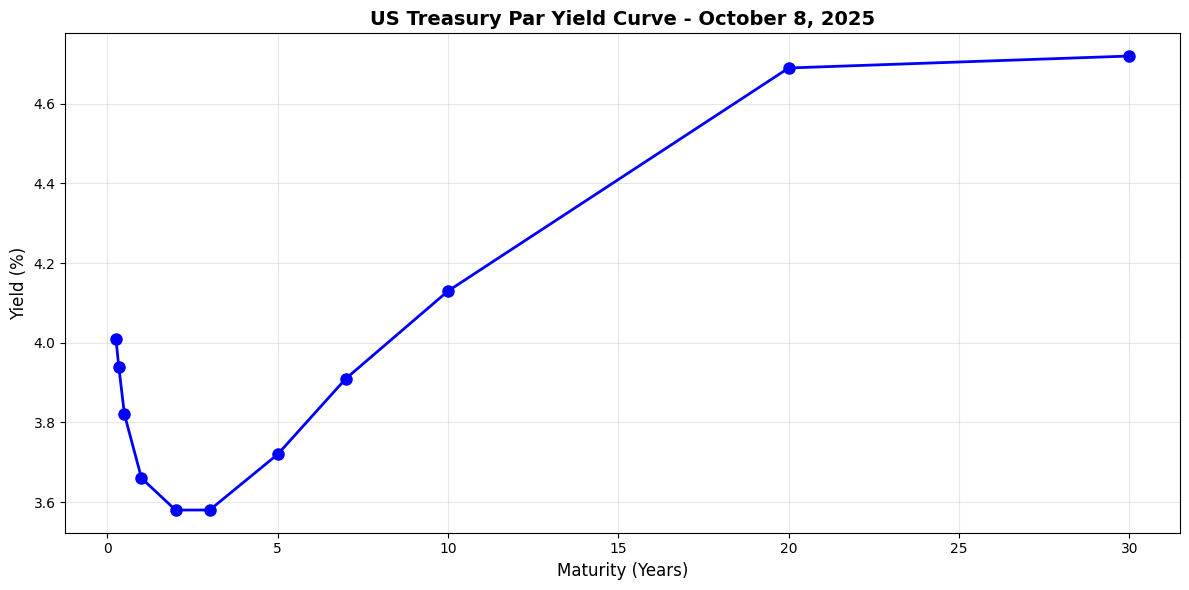

In [69]:
# REAL DATA from US Treasury as of October 8, 2025 from https://home.treasury.gov/resource-center/data-chart-center/interest-rates
treasury_yields = {
    'Maturity': ['3 Mo', '4 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr'],
    'Years': [0.25, 0.333, 0.5, 1, 2, 3, 5, 7, 10, 20, 30],
    'Yield_Pct': [4.01, 3.94, 3.82, 3.66, 3.58, 3.58, 3.72, 3.91, 4.13, 4.69, 4.72]
}

yields_df = pd.DataFrame(treasury_yields)
yields_df['Yield_Decimal'] = yields_df['Yield_Pct'] / 100

print("US Treasury Par Yield Curve (October 8, 2025):")
print(yields_df.to_string(index=False))

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(yields_df['Years'], yields_df['Yield_Pct'], 'b-o', linewidth=2, markersize=8)
plt.xlabel('Maturity (Years)', fontsize=12)
plt.ylabel('Yield (%)', fontsize=12)
plt.title('US Treasury Par Yield Curve - October 8, 2025', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [70]:
# Current date
valuation_date = datetime(2025, 10, 8)

# Calculate days and years to each payment
liabilities_df['Days_to_Payment'] = (liabilities_df['Date'] - valuation_date).dt.days
liabilities_df['Years_to_Payment'] = liabilities_df['Days_to_Payment'] / 365

print(f"Valuation Date: {valuation_date.strftime('%B %d, %Y')}")
print("\nTime to Each Payment:")
print(liabilities_df[['Date', 'Payment_Million', 'Days_to_Payment', 'Years_to_Payment']].to_string(index=False))

Valuation Date: October 08, 2025

Time to Each Payment:
      Date  Payment_Million  Days_to_Payment  Years_to_Payment
2026-03-31                8              174          0.476712
2026-09-30               10              357          0.978082
2027-03-31               11              539          1.476712
2027-09-30                9              722          1.978082
2028-03-31               10              905          2.479452
2028-09-30                9             1088          2.980822
2029-03-31               12             1270          3.479452
2029-09-30                8             1453          3.980822
2030-03-31               10             1635          4.479452
2030-09-30                7             1818          4.980822
2031-03-31                5             2000          5.479452
2031-09-30                8             2183          5.980822
2032-03-31                7             2366          6.482192
2032-09-30               10             2549          6.983562

We convert the treasury par yield curve into a set of discount factors that can be used to value each liability cash flow.

1. Short maturities (up to 1 year):  
   These are effectively zero coupon instruments, so we compute discount factors directly using the quoted yield.

2. Longer maturities (more than 1 year):  
   Treasuries are coupon bearing with semiannual coupons. We apply the par bond pricing formula:  
   - Use already bootstrapped discount factors for earlier coupon dates.  
   - Solve for the discount factor at the new maturity.  

3. Build the discount factor curve:  
   Once discount factors are known at the standard maturities, we interpolate the curve to estimate discount factors at the exact liability payment dates.

4. Discount liabilities:  
   For each payment, we multiply the cash flow by its discount factor to get its present value.  
   The sum of these present values gives the total present value of the liability stream.


In [71]:
def df_semiannual(y, T):
    return (1 + y/2)**(-2*T)

DFs = {}

for _, row in yields_df.iterrows():
    T, y = float(row['Years']), float(row['Yield_Decimal'])
    if T <= 1.0:
        DFs[round(T,6)] = df_semiannual(y, T)

def is_integer_semiannual(T):
    return abs(2*T - round(2*T)) < 1e-9

for _, row in yields_df.iterrows():
    T, y = float(row['Years']), float(row['Yield_Decimal'])
    if T > 1.0 and is_integer_semiannual(T):
        n = int(round(2*T))
        c = y/2
        pv_coupons = 0.0
        for i in range(1, n):
            ti = i/2
            key = round(ti,6)
            if key not in DFs:
                known_T = np.array(sorted(DFs.keys()))
                known_DF = np.array([DFs[k] for k in known_T])
                DFs[key] = float(np.interp(ti, known_T, known_DF))
            pv_coupons += 100*c * DFs[key]
        DF_T = (100 - pv_coupons) / (100*(1+c))
        DFs[round(T,6)] = DF_T

df_curve = pd.DataFrame({'Years': list(DFs.keys()), 'DF': list(DFs.values())}).sort_values('Years').reset_index(drop=True)

def df_interp(t):
    T_known = df_curve['Years'].values
    DF_known = df_curve['DF'].values
    return float(np.interp(t, T_known, DF_known))

liabilities_df['DF'] = liabilities_df['Years_to_Payment'].apply(df_interp)
liabilities_df['PV_Million'] = liabilities_df['Payment_Million'] * liabilities_df['DF']
total_pv = liabilities_df['PV_Million'].sum()

print("Bootstrapped discount factors (head/tail):")
df_curve.head().to_string
df_curve.tail()

print("\nLiabilities with discount factors and PV (in millions):")
display(liabilities_df[['Date','Payment_Million','Years_to_Payment','DF','PV_Million']])

display(df_curve)

print(f"\nTotal Present Value of Liability Stream: {total_pv:,.2f} million")


Bootstrapped discount factors (head/tail):

Liabilities with discount factors and PV (in millions):


,Date,Payment_Million,Years_to_Payment,DF,PV_Million
0,2026-03-31,8,0.476712,0.982071,7.856571
1,2026-09-30,10,0.978082,0.965121,9.651205
2,2027-03-31,11,1.476712,0.964381,10.608188
3,2027-09-30,9,1.978082,0.932694,8.394247
4,2028-03-31,10,2.479452,0.931241,9.312414
5,2028-09-30,9,2.980822,0.899746,8.097710
6,2029-03-31,12,3.479452,0.898489,10.781871
7,2029-09-30,8,3.980822,0.898489,7.187914
8,2030-03-31,10,4.479452,0.898489,8.984893
9,2030-09-30,7,4.980822,0.831632,5.821423


,Years,DF
0,0.250,0.990123
1,0.333,0.987091
2,0.500,0.981258
3,1.000,0.964381
4,1.500,0.964381
...,...,...
57,28.000,0.306801
58,28.500,0.306801
59,29.000,0.306801
60,29.500,0.306801



Total Present Value of Liability Stream: 125.25 million


In [72]:
#LP

instruments_df = pd.read_csv('instrumentSet.csv')
settlement_date = datetime(2025, 10, 8)

instruments_df['Maturity'] = pd.to_datetime(instruments_df['Maturity'])
instruments_df['Coupon Rate'] = pd.to_numeric(instruments_df['Coupon Rate'].str.rstrip('%'), errors='coerce')

# Liability schedule from the project description
liability_data = {
    'Date': [
        'Mar 2026', 'Sep 2026', 'Mar 2027', 'Sep 2027',
        'Mar 2028', 'Sep 2028', 'Mar 2029', 'Sep 2029',
        'Mar 2030', 'Sep 2030', 'Mar 2031', 'Sep 2031',
        'Mar 2032', 'Sep 2032', 'Mar 2033', 'Sep 2033'
    ],
    'Payment_Million': [8, 10, 11, 9, 10, 9, 12, 8, 10, 7, 5, 8, 7, 10, 9, 10]
}

# Convert to actual dates (assuming end of month for Mar, actual date for Sep)
liability_dates = [
    datetime(2026, 3, 31), datetime(2026, 9, 30),
    datetime(2027, 3, 31), datetime(2027, 9, 30),
    datetime(2028, 3, 31), datetime(2028, 9, 30),
    datetime(2029, 3, 31), datetime(2029, 9, 30),
    datetime(2030, 3, 31), datetime(2030, 9, 30),
    datetime(2031, 3, 31), datetime(2031, 9, 30),
    datetime(2032, 3, 31), datetime(2032, 9, 30),
    datetime(2033, 3, 31), datetime(2033, 9, 30)
]

liabilities_df = pd.DataFrame({
    'Date': liability_dates,
    'Payment_Million': liability_data['Payment_Million']
})

print("Liability Payment Schedule:")
print(liabilities_df.to_string(index=False))
print(f"\nTotal Liabilities: ${liabilities_df['Payment_Million'].sum():.2f} million")


# Function to generate cash flows for each bond
def generate_bond_cashflows(row, settlement_date):
    """
    Generate all cash flows for a bond from settlement to maturity.
    Returns list of (date, amount_per_100_face) tuples.
    """
    cashflows = []
    maturity = row['Maturity']
    coupon_rate = row['Coupon Rate'] / 100.0  # Convert percentage to decimal

    # Check if bond has already matured
    if maturity <= settlement_date:
        return cashflows

    # Treasury Bills (zero coupon)
    if coupon_rate == 0:
        cashflows.append((maturity, 100.0))  # Pay face value at maturity
    else:
        # Treasury Notes/Bonds (coupon-bearing)
        # Determine coupon payment dates based on maturity date
        # US Treasuries pay semi-annually on the maturity month/day
        coupon_amount = coupon_rate * 100 / 2  # Semi-annual coupon per $100 face

        # Generate all coupon dates from maturity backwards
        current_coupon_date = maturity
        coupon_dates = []

        while current_coupon_date > settlement_date:
            coupon_dates.append(current_coupon_date)
            current_coupon_date = current_coupon_date - relativedelta(months=6)

        # Reverse to get chronological order
        coupon_dates.reverse()

        # Add coupon payments
        for coupon_date in coupon_dates:
            cashflows.append((coupon_date, coupon_amount))

        # Add principal payment at maturity
        cashflows.append((maturity, 100.0))

    return cashflows

# Build cash flow matrix
# Rows = instruments, Columns = liability periods
print("\n" + "=" * 80)
print("GENERATING CASH FLOW MATRIX")
print("=" * 80)

n_instruments = len(instruments_df)
n_periods = len(liabilities_df)

# Create cash flow matrix: cash_flow[i, t] = cash received from bond i during period t
cash_flow_matrix = np.zeros((n_instruments, n_periods))

period_ends = liabilities_df['Date'].to_list()
period_starts = [settlement_date] + period_ends[:-1]

for i, instrument in instruments_df.iterrows():
    cashflows = generate_bond_cashflows(instrument, settlement_date)

    for cf_date, cf_amount in cashflows:
        for t in range(n_periods):
            if (cf_date > period_starts[t]) and (cf_date <= period_ends[t]):
                cash_flow_matrix[i, t] += cf_amount
                break

print(f"Cash flow matrix shape: {cash_flow_matrix.shape}")
print(f"Non-zero entries: {np.count_nonzero(cash_flow_matrix)}")

# Create Gurobi model
print("\n" + "=" * 80)
print("BUILDING LINEAR PROGRAM")
print("=" * 80)

model = gp.Model("BondDedication")
model.setParam('OutputFlag', 1)  # Show solver output

# Decision variables: x[i] = face value (in millions) of bond i to purchase
x = model.addVars(n_instruments, lb=0, vtype=GRB.CONTINUOUS, name="bond")

# Cash balance variables: c[t] = cash carried forward from period t to t+1
c = model.addVars(n_periods, lb=0, vtype=GRB.CONTINUOUS, name="cash")

print(f"Decision variables: {n_instruments} bonds + {n_periods} cash balances")

# Objective: Minimize total cost of portfolio
# Cost = sum of (price/100 * face_value) for each bond
costs = instruments_df['Price'].values / 100.0  # Price per $1 face value
model.setObjective(
    gp.quicksum(costs[i] * x[i] for i in range(n_instruments)),
    GRB.MINIMIZE
)

print("Objective: Minimize total portfolio cost")

# Constraints: Cash flow matching for each period
print(f"Adding {n_periods} cash flow matching constraints...")

for t in range(n_periods):
    liability = liabilities_df['Payment_Million'].iloc[t]

    # Cash inflow = bond payments + cash from previous period
    cash_inflow = gp.quicksum(
        (cash_flow_matrix[i, t] / 100.0) * x[i] for i in range(n_instruments)
    )

    if t > 0:
        cash_inflow += c[t-1]  # Add cash carried from previous period

    # Cash outflow = liability payment + cash carried to next period
    if t < n_periods - 1:
        model.addConstr(cash_inflow == liability + c[t],
                       name=f"cashflow_{t}")
    else:
        # Last period: no cash carryforward needed
        model.addConstr(cash_inflow == liability,
                       name=f"cashflow_{t}")

print(f"Total constraints: {model.NumConstrs}")

# Solve the model
print("\n" + "=" * 80)
print("SOLVING LINEAR PROGRAM")
print("=" * 80)

model.optimize()

# Display results
print("\n" + "=" * 80)
print("OPTIMIZATION RESULTS")
print("=" * 80)

if model.status == GRB.OPTIMAL:
    print(f"\nOptimal Solution Found!")
    print(f"Total Portfolio Cost: ${model.objVal:.2f} million")
    print(f"Total Liabilities: ${liabilities_df['Payment_Million'].sum():.2f} million")
    print(f"Cost Efficiency: {(model.objVal / liabilities_df['Payment_Million'].sum() - 1) * 100:.4f}% above face value")

    # Extract solution
    bond_holdings = [x[i].X for i in range(n_instruments)]
    cash_balances = [c[t].X for t in range(n_periods)]

    # Display portfolio composition
    print("\n" + "=" * 80)
    print("PORTFOLIO COMPOSITION")
    print("=" * 80)

    portfolio_df = instruments_df.copy()
    portfolio_df['Face_Value_Million'] = bond_holdings
    portfolio_df['Cost_Million'] = portfolio_df['Face_Value_Million'] * portfolio_df['Price'] / 100.0

    # Filter to bonds actually purchased
    portfolio_df = portfolio_df[portfolio_df['Face_Value_Million'] > 0.001].copy()
    portfolio_df = portfolio_df.sort_values('Maturity')

    print(f"\nNumber of bonds in portfolio: {len(portfolio_df)}")
    print("\nBonds held:")
    display_cols = ['Type', 'CUSIP', 'Maturity', 'Coupon Rate', 'Price',
                   'Face_Value_Million', 'Cost_Million']
    print(portfolio_df[display_cols].to_string(index=False))

    # Cash balance schedule
    print("\n" + "=" * 80)
    print("CASH BALANCE SCHEDULE")
    print("=" * 80)

    cash_schedule = pd.DataFrame({
        'Period': liabilities_df['Date'],
        'Liability': liabilities_df['Payment_Million'],
        'Cash_Carried_Forward': cash_balances
    })
    print(cash_schedule.to_string(index=False))

    # Summary statistics
    print("\n" + "=" * 80)
    print("SUMMARY STATISTICS")
    print("=" * 80)
    print(f"Total Portfolio Cost: ${model.objVal:.2f} million")
    print(f"Total Liabilities: ${liabilities_df['Payment_Million'].sum():.2f} million")
    print(f"Total Cash Held: ${sum(cash_balances):.2f} million")
    print(f"Average Cash Balance: ${np.mean(cash_balances):.2f} million")
    print(f"Max Cash Balance: ${max(cash_balances):.2f} million")

else:
    print(f"\nOptimization failed with status: {model.status}")
    print("No feasible solution found.")


Liability Payment Schedule:
      Date  Payment_Million
2026-03-31                8
2026-09-30               10
2027-03-31               11
2027-09-30                9
2028-03-31               10
2028-09-30                9
2029-03-31               12
2029-09-30                8
2030-03-31               10
2030-09-30                7
2031-03-31                5
2031-09-30                8
2032-03-31                7
2032-09-30               10
2033-03-31                9
2033-09-30               10

Total Liabilities: $143.00 million

GENERATING CASH FLOW MATRIX
Cash flow matrix shape: (30, 16)
Non-zero entries: 121

BUILDING LINEAR PROGRAM
Set parameter OutputFlag to value 1
Decision variables: 30 bonds + 16 cash balances
Objective: Minimize total portfolio cost
Adding 16 cash flow matching constraints...
Total constraints: 0

SOLVING LINEAR PROGRAM
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M4 Pro
Thread count: 14 physical co

Extracting implied discount factors from LP dual variables...

Portfolio-Implied Discount Factors:
   Years       DF
0.476712 0.987413
0.978082 0.981217
1.476712 0.964526
1.978082 0.929584
2.479452 0.929584
2.980822 0.900680
3.479452 0.882780
3.980822 0.882780
4.479452 0.882780
4.980822 0.829081
5.479452 0.829081
5.980822 0.688248
6.482192 0.688248
6.983562 0.688248
7.482192 0.688248
7.983562 0.688248

Portfolio-Implied Continuous Spots (%):
   Years  SpotPct
0.476712 2.657180
0.978082 1.938641
1.476712 2.445890
1.978082 3.691340
2.479452 2.944914
2.980822 3.509257
3.479452 3.583304
3.980822 3.132000
4.479452 2.783362
4.980822 3.763187
5.479452 3.420737
5.980822 6.246732
6.482192 5.763574
6.983562 5.349791
7.482192 4.993269
7.983562 4.679690

Comparison (Treasury vs Portfolio-Implied):
   Years  Treasury_Spot_%  Portfolio_Spot_%  Spread_bps
0.476712         3.795001          2.657180 -113.782094
0.978082         3.629785          1.938641 -169.114454
1.476712         2.456074          

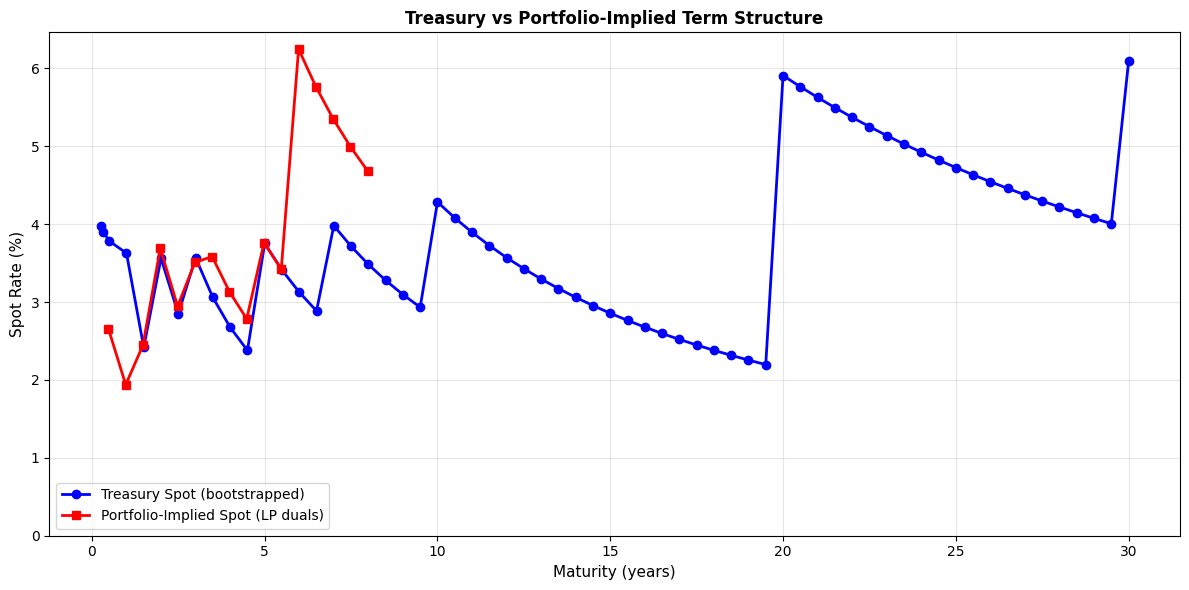

In [77]:
print("Extracting implied discount factors from LP dual variables...")
print("=" * 80)

valuation_date = datetime(2025, 10, 8)
liabilities_df['Days_to_Payment'] = (liabilities_df['Date'] - valuation_date).dt.days
liabilities_df['Years_to_Payment'] = liabilities_df['Days_to_Payment'] / 365

implied = []
for t in range(len(liabilities_df)):
    constr = model.getConstrByName(f"cashflow_{t}")
    df_t = constr.Pi  # dual IS the discount factor here
    T = float(liabilities_df['Years_to_Payment'].iloc[t])
    implied.append({'Years': T, 'DF': df_t})

implied_df = pd.DataFrame(implied).sort_values('Years').reset_index(drop=True)
implied_df['Spot_Cont'] = -np.log(implied_df['DF']) / implied_df['Years']

def df_interp(t):
    T_known = df_curve['Years'].values
    DF_known = df_curve['DF'].values
    return float(np.interp(t, T_known, DF_known))

liabilities_df['DF'] = liabilities_df['Years_to_Payment'].apply(df_interp)
treasury_spot = -np.log(liabilities_df['DF']) / liabilities_df['Years_to_Payment']

print("\nPortfolio-Implied Discount Factors:")
print(implied_df[['Years','DF']].to_string(index=False))

print("\nPortfolio-Implied Continuous Spots (%):")
print((implied_df.assign(SpotPct=100*implied_df['Spot_Cont']))[['Years','SpotPct']].to_string(index=False))

comparison_df = pd.DataFrame({
    'Years': implied_df['Years'],
    'Treasury_Spot_%': 100*treasury_spot.values,
    'Portfolio_Spot_%': 100*implied_df['Spot_Cont'].values,
    'Spread_bps': 10000*(implied_df['Spot_Cont'].values - treasury_spot.values)
})

print("\nComparison (Treasury vs Portfolio-Implied):")
print(comparison_df.to_string(index=False))

plt.figure(figsize=(12,6))
plt.plot(df_curve['Years'], -np.log(df_curve['DF'])/df_curve['Years']*100, 'b-o', linewidth=2, markersize=6, label='Treasury Spot (bootstrapped)')
plt.plot(implied_df['Years'], implied_df['Spot_Cont']*100, 'r-s', linewidth=2, markersize=6, label='Portfolio-Implied Spot (LP duals)')
plt.xlabel('Maturity (years)', fontsize=11)
plt.ylabel('Spot Rate (%)', fontsize=11)
plt.title('Treasury vs Portfolio-Implied Term Structure', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()


The chart shows that while the Treasury curve is smooth and positive, the portfolio-implied curve is jagged with negative segments because of the 0% reinvestment rule and bond/liability timing mismatches, highlighting the cost and inefficiency of building a dedicated portfolio under these constraints.

In [74]:
#LP with Corporates

treasury_df = pd.read_csv('instrumentSet.csv')
corporate_df = pd.read_csv('corporateBonds.csv')  # Data from FINRA

for df_in in [treasury_df, corporate_df]:
    df_in['Maturity'] = pd.to_datetime(df_in['Maturity'])
    df_in['Coupon Rate'] = pd.to_numeric(df_in['Coupon Rate'].str.rstrip('%'), errors='coerce')

treasury_df['Source'] = 'Treasury'
corporate_df['Source'] = 'Corporate'

instruments_df = pd.concat([treasury_df, corporate_df], ignore_index=True)

n_instruments = len(instruments_df)
n_periods = len(liabilities_df)

print(f"Total instruments: {n_instruments} (Treasuries: {len(treasury_df)}, Corporates: {len(corporate_df)})")

# === Build cash flow matrix for new universe ===
cash_flow_matrix = np.zeros((n_instruments, n_periods))

period_ends = liabilities_df['Date'].to_list()
period_starts = [settlement_date] + period_ends[:-1]

for i, instrument in instruments_df.iterrows():
    cashflows = generate_bond_cashflows(instrument, settlement_date)
    for cf_date, cf_amount in cashflows:
        for t in range(n_periods):
            if (cf_date > period_starts[t]) and (cf_date <= period_ends[t]):
                cash_flow_matrix[i, t] += cf_amount
                break

print(f"Cash flow matrix shape: {cash_flow_matrix.shape}")
print(f"Non-zero entries: {np.count_nonzero(cash_flow_matrix)}")

# === Build Gurobi model ===
print("\n" + "=" * 80)
print("BUILDING LINEAR PROGRAM (with corporates)")
print("=" * 80)

model = gp.Model("BondDedication_withCorporates")
model.setParam('OutputFlag', 1)

# Decision variables
x = model.addVars(n_instruments, lb=0, vtype=GRB.CONTINUOUS, name="bond")
c = model.addVars(n_periods, lb=0, vtype=GRB.CONTINUOUS, name="cash")

print(f"Decision variables: {n_instruments} bonds + {n_periods} cash balances")

# Objective: minimize cost
costs = instruments_df['Price'].values / 100.0
model.setObjective(gp.quicksum(costs[i] * x[i] for i in range(n_instruments)), GRB.MINIMIZE)

print("Objective: Minimize total portfolio cost")

# Constraints: liability coverage
print(f"Adding {n_periods} cash flow matching constraints...")

for t in range(n_periods):
    liability = liabilities_df['Payment_Million'].iloc[t]
    cash_inflow = gp.quicksum((cash_flow_matrix[i, t] / 100.0) * x[i] for i in range(n_instruments))
    if t > 0:
        cash_inflow += c[t-1]
    if t < n_periods - 1:
        model.addConstr(cash_inflow == liability + c[t], name=f"cashflow_{t}")
    else:
        model.addConstr(cash_inflow == liability, name=f"cashflow_{t}")

# Extra constraint: at most 50% of portfolio cost from corporates
corporate_idx = instruments_df[instruments_df['Source'] == 'Corporate'].index.tolist()
total_cost = gp.quicksum(costs[i] * x[i] for i in range(n_instruments))
corporate_cost = gp.quicksum(costs[i] * x[i] for i in corporate_idx)
model.addConstr(corporate_cost <= 0.5 * total_cost, name="corporate_limit")

print(f"Total constraints: {model.NumConstrs}")

# Solve
print("\n" + "=" * 80)
print("SOLVING LINEAR PROGRAM")
print("=" * 80)

model.optimize()

# === Results ===
print("\n" + "=" * 80)
print("OPTIMIZATION RESULTS")
print("=" * 80)

if model.status == GRB.OPTIMAL:
    print("\nOptimal Solution Found with Corporates included!")
    print(f"Total Portfolio Cost: ${model.objVal:.2f} million")
    print(f"Total Liabilities: ${liabilities_df['Payment_Million'].sum():.2f} million")
    print(f"Cost Efficiency: {(model.objVal / liabilities_df['Payment_Million'].sum() - 1) * 100:.4f}% above face value")

    bond_holdings = [x[i].X for i in range(n_instruments)]
    cash_balances = [c[t].X for t in range(n_periods)]

    portfolio_df = instruments_df.copy()
    portfolio_df['Face_Value_Million'] = bond_holdings
    portfolio_df['Cost_Million'] = portfolio_df['Face_Value_Million'] * portfolio_df['Price'] / 100.0
    portfolio_df = portfolio_df[portfolio_df['Face_Value_Million'] > 0.001].copy()
    portfolio_df = portfolio_df.sort_values('Maturity')

    print("\nPortfolio Composition:")
    display_cols = ['Source', 'Type', 'CUSIP', 'Maturity', 'Coupon Rate', 'Price',
                   'Face_Value_Million', 'Cost_Million']
    print(portfolio_df[display_cols].to_string(index=False))

    print("\nCash Balances:")
    cash_schedule = pd.DataFrame({
        'Period': liabilities_df['Date'],
        'Liability': liabilities_df['Payment_Million'],
        'Cash_Carried_Forward': cash_balances
    })
    print(cash_schedule.to_string(index=False))

else:
    print(f"\nOptimization failed with status: {model.status}")
    print("No feasible solution found.")


Total instruments: 35 (Treasuries: 30, Corporates: 5)
Cash flow matrix shape: (35, 16)
Non-zero entries: 173

BUILDING LINEAR PROGRAM (with corporates)
Set parameter OutputFlag to value 1
Decision variables: 35 bonds + 16 cash balances
Objective: Minimize total portfolio cost
Adding 16 cash flow matching constraints...
Total constraints: 0

SOLVING LINEAR PROGRAM
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M4 Pro
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Optimize a model with 17 rows, 51 columns and 238 nonzeros
Model fingerprint: 0x9c06f8c0
Coefficient statistics:
  Matrix range     [6e-03, 1e+00]
  Objective range  [9e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+01]
Presolve removed 0 rows and 3 columns
Presolve time: 0.00s
Presolved: 17 rows, 48 columns, 234 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00  

Extracting implied discount factors from LP dual variables...

Portfolio-Implied Discount Factors:
   Years       DF
0.476712 0.987413
0.978082 0.981217
1.476712 0.964526
1.978082 0.929584
2.479452 0.929584
2.980822 0.900680
3.479452 0.882780
3.980822 0.882780
4.479452 0.882780
4.980822 0.829081
5.479452 0.829081
5.980822 0.688248
6.482192 0.688248
6.983562 0.688248
7.482192 0.688248
7.983562 0.688248

Portfolio-Implied Continuous Spots (%):
   Years  SpotPct
0.476712 2.657180
0.978082 1.938641
1.476712 2.445890
1.978082 3.691340
2.479452 2.944914
2.980822 3.509257
3.479452 3.583304
3.980822 3.132000
4.479452 2.783362
4.980822 3.763187
5.479452 3.420737
5.980822 6.246732
6.482192 5.763574
6.983562 5.349791
7.482192 4.993269
7.983562 4.679690

Comparison (Treasury vs Portfolio-Implied):
   Years  Treasury_Spot_%  Portfolio_Spot_%  Spread_bps
0.476712         3.795001          2.657180 -113.782094
0.978082         3.629785          1.938641 -169.114454
1.476712         2.456074          

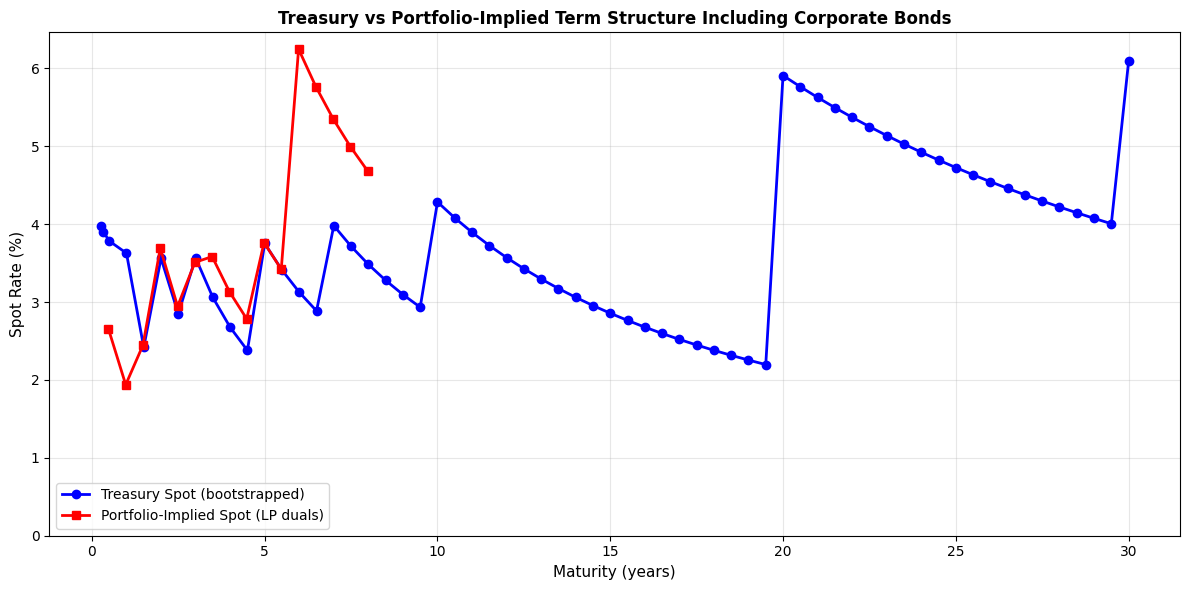

In [78]:
print("Extracting implied discount factors from LP dual variables...")
print("=" * 80)

valuation_date = datetime(2025, 10, 8)
liabilities_df['Days_to_Payment'] = (liabilities_df['Date'] - valuation_date).dt.days
liabilities_df['Years_to_Payment'] = liabilities_df['Days_to_Payment'] / 365

implied = []
for t in range(len(liabilities_df)):
    constr = model.getConstrByName(f"cashflow_{t}")
    df_t = constr.Pi  # dual IS the discount factor here
    T = float(liabilities_df['Years_to_Payment'].iloc[t])
    implied.append({'Years': T, 'DF': df_t})

implied_df = pd.DataFrame(implied).sort_values('Years').reset_index(drop=True)
implied_df['Spot_Cont'] = -np.log(implied_df['DF']) / implied_df['Years']

def df_interp(t):
    T_known = df_curve['Years'].values
    DF_known = df_curve['DF'].values
    return float(np.interp(t, T_known, DF_known))

liabilities_df['DF'] = liabilities_df['Years_to_Payment'].apply(df_interp)
treasury_spot = -np.log(liabilities_df['DF']) / liabilities_df['Years_to_Payment']

print("\nPortfolio-Implied Discount Factors:")
print(implied_df[['Years','DF']].to_string(index=False))

print("\nPortfolio-Implied Continuous Spots (%):")
print((implied_df.assign(SpotPct=100*implied_df['Spot_Cont']))[['Years','SpotPct']].to_string(index=False))

comparison_df = pd.DataFrame({
    'Years': implied_df['Years'],
    'Treasury_Spot_%': 100*treasury_spot.values,
    'Portfolio_Spot_%': 100*implied_df['Spot_Cont'].values,
    'Spread_bps': 10000*(implied_df['Spot_Cont'].values - treasury_spot.values)
})

print("\nComparison (Treasury vs Portfolio-Implied):")
print(comparison_df.to_string(index=False))

plt.figure(figsize=(12,6))
plt.plot(df_curve['Years'], -np.log(df_curve['DF'])/df_curve['Years']*100, 'b-o', linewidth=2, markersize=6, label='Treasury Spot (bootstrapped)')
plt.plot(implied_df['Years'], implied_df['Spot_Cont']*100, 'r-s', linewidth=2, markersize=6, label='Portfolio-Implied Spot (LP duals)')
plt.xlabel('Maturity (years)', fontsize=11)
plt.ylabel('Spot Rate (%)', fontsize=11)
plt.title('Treasury vs Portfolio-Implied Term Structure Including Corporate Bonds', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()
